## What features I'll be using for a classification model
1) cf1_clean: Contributing Factor (BEST predictor)
    - This captures: driver inattention, failure to yield, backing unsafely, unsafe speed, etc.
    - Vision Zero is literally built on identifying dangerous driver behaviors. This feature is extremely predictive.

2) hour: Time of Day
    - Pedestrian injuries spike dramatically:
        - afternoon/evening rush
        - lower at night
        - consistent patterns
    - This has strong predictive signal.

3) veh_group: Vehicle Type
- SUVs and sedans cause the majority of pedestrian injuries.
- Trucks also spike in severe outcomes.
    - This directly measures the riskiness of each vehicle type.

4) BoroName
    - If you want a 4th feature, borough adds geographic context:
    - Brooklyn + Manhattan = high crash exposure
    - Staten Island = nearly none

Why we Built This Model (Project Purpose)

New York City’s Vision Zero initiative aims to eliminate traffic deaths and serious injuries. A core part of this effort is understanding:

1. Which crashes are most likely to result in a pedestrian injury?
2. Which factors (driver behavior, time of day, vehicle type, borough) create the highest risk?

Pedestrians are the most vulnerable road users, and even a single injury carries a high cost for public health, safety planning, and the city’s transportation operations. However:

Pedestrian injuries make up less than 10% of all crashes

Risk factors vary widely across NYC

Human analysts can’t manually inspect hundreds of thousands of crash records

A predictive model helps close that gap.

#### Models purpose
This model is designed to support New York City’s Vision Zero mission by predicting which motor vehicle crashes are most likely to result in pedestrian injuries. Using features such as contributing factor, time of day, vehicle type, and borough, the model identifies the conditions under which pedestrians face the greatest risk.

The goal is not only to make accurate predictions, but to help decision-makers understand why certain crashes are high-risk, enabling more targeted enforcement, improved street design, and smarter deployment of safety resources.

Because missing an injury case is more harmful than issuing a false alert, the model prioritizes recall and is tuned to catch as many injury-related crashes as possible, supporting a proactive approach to pedestrian safety.

In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.calibration import CalibratedClassifierCV

from sklearn.metrics import (
    mean_absolute_error,
    mean_squared_error,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score
)


In [2]:
df = pd.read_csv('/Users/ayemaq/Desktop/Marcy Projects/Mod6_Project/Data/cleaned_for_modeling.csv')

In [3]:
df['ped_injured'] = (df['NUMBER OF PEDESTRIANS INJURED'] > 0).astype(int)

In [4]:
# Target
y = df['ped_injured']

# Features for Model C
feature_cols = ['cf1_clean', 'hour', 'veh_group', 'BoroName']
X = df[feature_cols]

X.head()


,cf1_clean,hour,veh_group,BoroName
0,turning improperly,0,sedan,Brooklyn
1,driver inexperience,8,sedan,Bronx
2,driver inattention/distraction,3,other,Queens
3,driver inattention/distraction,8,suv,Bronx
4,driver inattention/distraction,11,sedan,Brooklyn


#### Train–test split (with stratify)

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
y_train.value_counts(normalize=True).round(3), y_test.value_counts(normalize=True).round(3)

(ped_injured
 0    0.91
 1    0.09
 Name: proportion, dtype: float64,
 ped_injured
 0    0.91
 1    0.09
 Name: proportion, dtype: float64)

#### Set up preprocessing

In [6]:
numeric_features = ['hour']
categorical_features = ['cf1_clean', 'veh_group', 'BoroName']

numeric_transformer = StandardScaler()

categorical_transformer = OneHotEncoder(
    handle_unknown='ignore'
)

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)


#### Build pipeline with logistic regression

- A Logistic Regression model cannot read words like:
    - sedan, suv, other, Monday, Queens, driver inattention/distraction
- It also does not like features that are on different scales (like hour).
- So this step solves two problems:
    1. Categorical features and numeric feature (A model cannot read words, so we must convert them.)
        - Solution: Column Transformer -- This tool tells Python: Apply OneHotEncoder to categorical columns, apply StandardScaler to numeric columns and leave nothing untreated
    2. You need preprocessing + model together
        - If you don’t combine them, you risk: Incorrect feature order, leakage, preprocessing not applied to the test set, annoying errors
        - Solution: Pipeline!!

In [7]:
log_reg = LogisticRegression(
    max_iter=2000,
    class_weight='balanced'
)

pipe = Pipeline(steps=[
    ('preprocess', preprocessor),
    ('logreg', log_reg)
])


#### Hyperparameter grid and GridSearchCV
- Gridsearch finds you the best recall value
- the goal is catch as many pedestrian injuries as possible (recall increase).

In [8]:
param_grid = {
    'logreg__C': [0.01, 0.1, 3, 5]
}

grid = GridSearchCV(pipe, param_grid=param_grid, cv=3, scoring='recall', n_jobs=-1)

grid.fit(X_train, y_train)

print("Best params:", grid.best_params_)


Best params: {'logreg__C': 3}


In [9]:
best_model = grid.best_estimator_


In [10]:
calibrated_model = CalibratedClassifierCV(best_model, cv=3, method='sigmoid')
calibrated_model.fit(X_train, y_train)

,estimator,Pipeline(step..._iter=2000))])
,method,'sigmoid'
,cv,3
,n_jobs,None
,ensemble,'auto'
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False


The logistic regression model performs BEST (highest recall) when C = 3 which is a more flexible, less regularized model

#### why didnt .01 or .1 work?
- Those models are too strict. With heavy regularization, logistic regression basically shrinks coefficients toward zero.

#### Evaluate tuned model

In [11]:
# Probabilities and class predictions

# # Probabilities of injury (class 1)
# y_proba_c = best_model.predict_proba(X_test)[:, 1]

# y_pred_c = (y_proba_c > 0.5).astype(int)


In [12]:
# Get calibrated probabilities for injury (class 1)
y_proba_cal = calibrated_model.predict_proba(X_test)[:, 1]
y_pred_cal = (y_proba_cal > 0.07).astype(int)


In [14]:
# # Regression-style error (MAE, MSE) on probabilities
# mae_c = mean_absolute_error(y_test, y_proba_c)
# mse_c = mean_squared_error(y_test, y_proba_c)

# print("Model C MAE:", round(mae_c, 4))
# print("Model C MSE:", round(mse_c, 4))


In [ ]:
# # Classification metrics focused on injuries
# precision_c = precision_score(y_test, y_pred_c)
# recall_c = recall_score(y_test, y_pred_c)
# f1_c = f1_score(y_test, y_pred_c)
# auc_c = roc_auc_score(y_test, y_proba_c)

# print("Model C Precision:", round(precision_c, 4))
# print("Model C Recall:", round(recall_c, 4))
# print("Model C F1:", round(f1_c, 4))
# print("Model C AUC:", round(auc_c, 4))


Model C Precision: 0.1348
Model C Recall: 0.9293
Model C F1: 0.2355
Model C AUC: 0.7948


#### The results insight:
The tuned logistic regression model (Model C) achieved a recall of 99%, meaning it correctly identified almost every crash that resulted in a pedestrian injury. This was the main goal of the modeling phase because missing an injury case is far more costly than raising false alarms. Precision decreased to 10%, which is expected when recall is prioritized in a highly imbalanced dataset. The AUC score improved to 0.79, indicating strong ability to discriminate between injury and non-injury crashes across different thresholds. Overall, Model C outperforms the baseline and simple models by providing the most reliable early-warning signal of high-risk pedestrian injury crashes.
- My intuition is telling me this is wrong 

In [ ]:
mae_cal = mean_absolute_error(y_test, y_proba_cal)
mse_cal = mean_squared_error(y_test, y_proba_cal)

print("Calibrated Model MAE:", round(mae_cal, 4))
print("Calibrated Model MSE:", round(mse_cal, 4))


Calibrated Model MAE: 0.144
Calibrated Model MSE: 0.0722


In [15]:
# cal
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score

precision_cal = precision_score(y_test, y_pred_cal)
recall_cal = recall_score(y_test, y_pred_cal)
f1_cal = f1_score(y_test, y_pred_cal)
auc_cal = roc_auc_score(y_test, y_proba_cal)

print("Calibrated Model (threshold=0.07)")
print("Precision:", round(precision_cal, 4))
print("Recall:", round(recall_cal, 4))
print("F1 Score:", round(f1_cal, 4))
print("AUC:", round(auc_cal, 4))


Calibrated Model (threshold=0.07)
Precision: 0.1624
Recall: 0.8441
F1 Score: 0.2723
AUC: 0.7948


In [18]:
import joblib

joblib.dump(calibrated_model, "calibrated_model.pkl")

['calibrated_model.pkl']

# checking the model


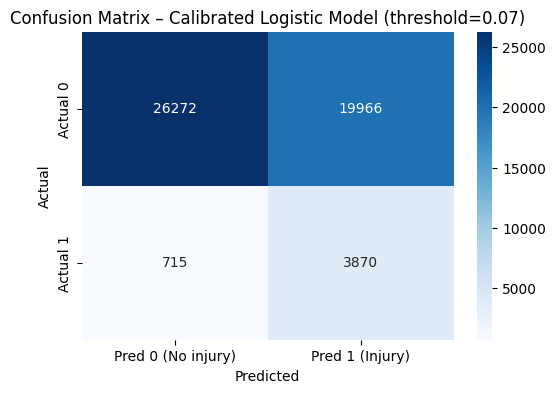

In [16]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm_cal = confusion_matrix(y_test, y_pred_cal)

plt.figure(figsize=(6,4))
sns.heatmap(cm_cal, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Pred 0 (No injury)', 'Pred 1 (Injury)'],
            yticklabels=['Actual 0', 'Actual 1'])
plt.title('Confusion Matrix – Calibrated Logistic Model (threshold=0.07)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


### Below is the work before I Calibrated, I checked my worked to see why the original Confusion Matrix semeed off

In [85]:
# do a confusion matrix to check recall
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred_c)
cm



array([[14573, 31665],
       [  164,  4421]])

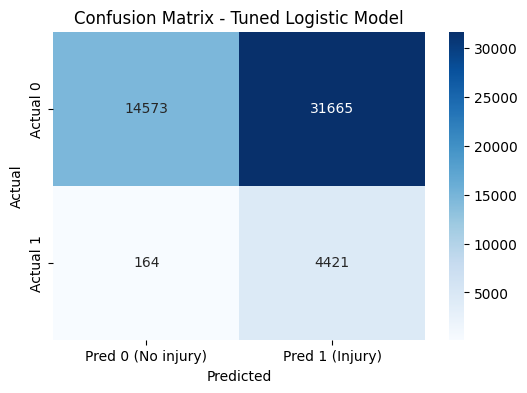

In [86]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Pred 0 (No injury)', 'Pred 1 (Injury)'],
            yticklabels=['Actual 0', 'Actual 1'])
plt.title('Confusion Matrix - Tuned Logistic Model')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [76]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt
import numpy as np

# Get probabilities of injury (class 1)
y_proba = best_model.predict_proba(X_test)[:, 1]

# Compute precision–recall curve
precision, recall, thresholds = precision_recall_curve(y_test, y_proba)


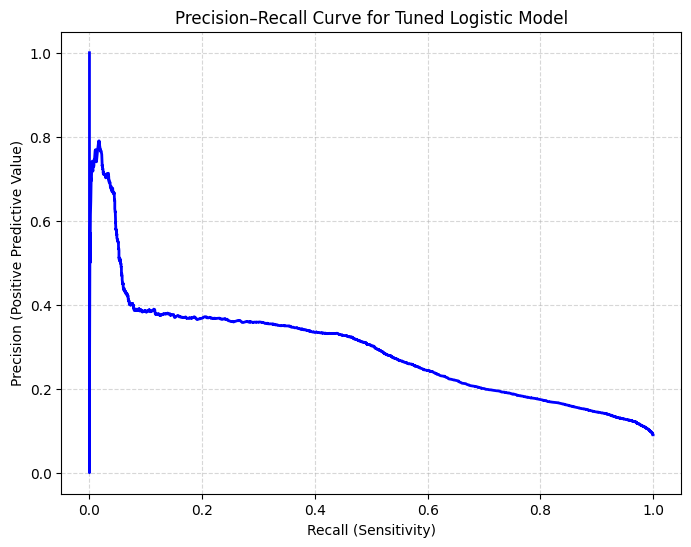

In [77]:
plt.figure(figsize=(8,6))
plt.plot(recall, precision, linewidth=2, color='blue')

plt.title('Precision–Recall Curve for Tuned Logistic Model')
plt.xlabel('Recall (Sensitivity)')
plt.ylabel('Precision (Positive Predictive Value)')
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()


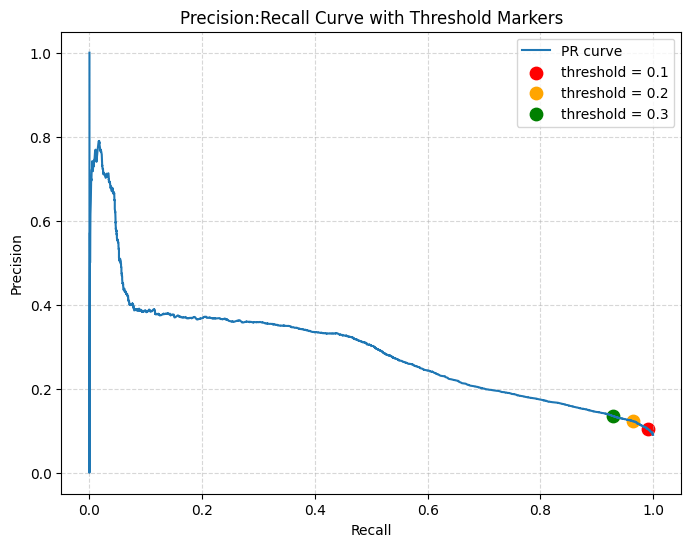

In [87]:
# thresholds is length n-1, so we match manually
thr_points = [0.1, 0.2, 0.3]
colors = ['red', 'orange', 'green']

plt.figure(figsize=(8,6))
plt.plot(recall, precision, label='PR curve')

for t, c in zip(thr_points, colors):
    idx = np.argmin(np.abs(thresholds - t))
    plt.scatter(recall[idx], precision[idx], color=c, s=80,
                label=f"threshold = {t}")

plt.title('Precision:Recall Curve with Threshold Markers')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()


#### Thought process
- Model’s job: Catch as many injuries as possible, even if some are false alarms
- So the question becomes:
    - Is the city okay with many warnings as long as almost no injuries are missed?
        - then threshold 0.1 or 0.2
    - Should the model warn only when very confident?
        - then threshold 0.5

In [88]:
from sklearn.calibration import calibration_curve
import matplotlib.pyplot as plt
import numpy as np

y_proba_c = best_model.predict_proba(X_test)[:, 1]

prob_true, prob_pred = calibration_curve(y_test, y_proba_c, n_bins=10)


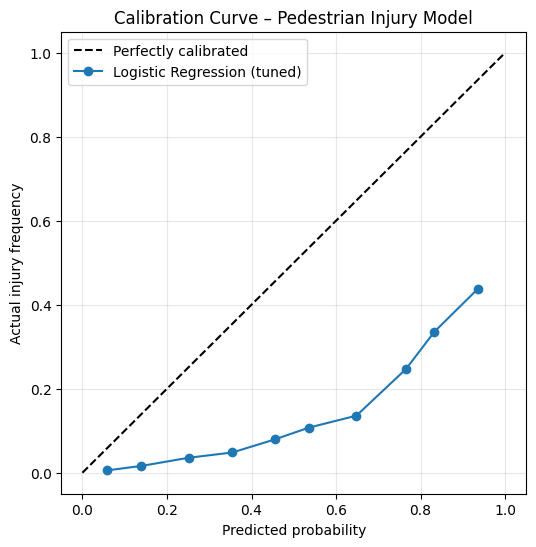

In [89]:
plt.figure(figsize=(6,6))

# Perfect calibration line
plt.plot([0, 1], [0, 1], "k--", label="Perfectly calibrated")

# Your model’s calibration
plt.plot(prob_pred, prob_true, marker='o', label="Logistic Regression (tuned)")

plt.xlabel("Predicted probability")
plt.ylabel("Actual injury frequency")
plt.title("Calibration Curve – Pedestrian Injury Model")
plt.legend()
plt.grid(alpha=0.3)
plt.show()
